# Simulating null distributions for outlier scans (part 1)

In [1]:
import msprime, tskit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import IPython.display

We are interested in understanding the divergence between two species. We will focus (perhaps wrongly...) on the most popular summary of pairwise differentiation: $F_{st}$. Let's assume that we have been analysing $F_{st}$ in windows of 32kb for a sample of 5 diploid individuals sampled in two recently diverged species and have observed some tantalizing outliers. We would like to show you how tools like **msprime** provide a means to get a feel for the expected variance in $F_{st}$ due to demography and recombination rate heterogeneity. We will ask ourselves the question: what are the key ingredients needed to gradually make the observed distribution of $F_{st}$ values more realistic? And how can this help us in interpreting those tantalizing outliers?

In this notebook, we will focus on the well on (the first half of) chromosome 18 in the well-described species pair _Heliconius melpomene_ and _H. cydno_. This chromosome contains _optix_, one of the three loci that determine wingpattern differences between the two species (blue bar). Average $F_{st}$ on chrom 18 is 0.196:

![From Jiggins et al. 2017 Phil Trans Roy Soc B 372:20150485](Heliconius_genetics.jpg)

$F_{st}$ scan for chrom 18 using sliding windows (32kb with 20% overlap)

0.1956776253965517

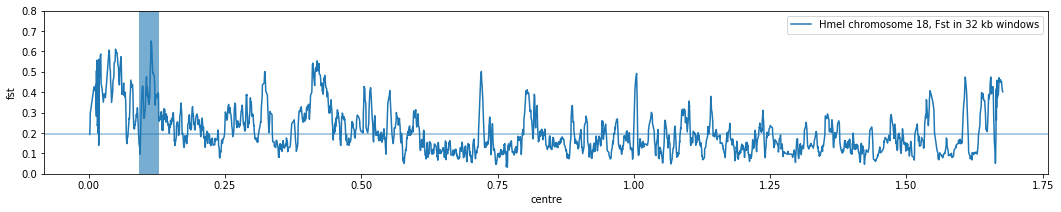

In [2]:
hmel18 = pd.read_csv('chrom18.csv')
hmel18.head()
genePos=(1058778+1159581)/2

fig, ax = plt.subplots(figsize=(18,3))
sns.lineplot(hmel18['centre']/10e6, hmel18['fst'],label='Hmel chromosome 18, Fst in 32 kb windows')
#horizontal line mean Fst with heterogeneity
plt.axvline(x=genePos/10e6, linewidth=20, alpha=0.6)
#add units for x-axis
plt.axhline(y=hmel18['fst'].mean(), alpha=0.5)
ax.set_ylim((0,0.8))
hmel18['fst'].mean()

$F_{st}$ has a wide distribution:

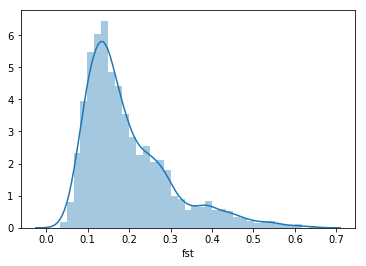

In [4]:
sns.distplot( hmel18['fst'], label='Fst in 32kb wins, n=20', norm_hist=True)

## 1. A super simple toy example

We want to get a feel for the distribution of windowise $F_{st}$ under a really simple null model given a realistic recombination rate (we will assume $r=1.84 10^-8$, the average per base from Davey et al. 2017). Let's define a history of strict divergence (i.e. no gene flow) at time $T=0.5$ ($\times 2N_e$ generations) between two populations of equal size ($N_e=500,000$) in __msprime__. These demographic parameters below are rounded estimates approximating the assumed true population history of the butterfly species pair.

In [ ]:
#number of samples (2Xof diploid individuals) per deme:
sample_size = 10

#Rates for migration, recombination and mutation are unscaled and per generation:
seqLength = 32e3 
recr = 1.84675e-8
Ne = 5e5
splitT = 5e5

population_configurations = [
    msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne),
    msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne),
    ]
#demographic events are specified in the order they occur backwards in time:
# MassMigration specifies the split between population 0 and 1: 
# backwards in time all lineages from the smaller population (1) are derived from pop (0)
# at time T 
demographic_events = [
    msprime.MassMigration(time=splitT, source=1, destination=0, proportion=1.0),
    ]

We want to simulate a largish - say 200 - number of replicate 32kb windows under this history in __msprime__.
Because simulating 32kb sequence chuncks is faster than simulating a whole chromosome AND because 200 replicates of 32 kb windows give us a better idea of the true variance in $F_st$ (given a specified demographic history) than simulating 200*32e3*0.2= 1280 kb. The latter is due to the fact that along a sequence trees are correlated. To estimate the variance, we would still have to run many replicates of the longer piece of sequence to get a distribution of the distribution of $F_st$ values. So in the worst case scenario we are a bit conservative by simulating $F_st$ for windowsize sequences.

In [ ]:
num_reps = 10
replicates = list(msprime.simulate(
        num_replicates = num_reps,
        length = seqLength, 
        recombination_rate = recr,
        population_configurations = population_configurations,
        demographic_events = demographic_events))

Note that we have not specified a mutation rate! All statistics we will be looking at can be calculated based on the branch lengths of the trees (see below). Bear in mind though that adding mutations should increase the variance in $F_st$.

In [ ]:
tree1 = replicates[0].first()
#colour map shows in which population samples coalesced
colour_map = {0:"red", 1:"blue"}
node_colours = {u: colour_map[tree1.population(u)] for u in tree1.nodes()}
IPython.display.SVG(tree1.draw(format="SVG",width=800, height=400,
                    node_colours=node_colours))

This is just one tree. What of length of sequence does one tree span? And how many trees are there within one 32kb window?

In [ ]:
lenlist=[[tree.length for tree in ts.trees()] for ts in replicates]
#add some text to tell what is what
print([len(l) for l in lenlist])
np.mean(lenlist[0])

Note that the tree sequence for each window contains about 5,000 marginal trees. The average span of a marginal tree is only 6 bases!

In [ ]:
#lenght distribution of the interval of the ARG/tree sequence for which the tree topology doesn't change
sns.distplot(lenlist[1], norm_hist=True)

In [ ]:
#small piece of code showing that none of the trees contain any mutations. (They can be added though with msprime)
list(replicates[0].variants())

We could sprinkle some mutations on the trees but this is not necessary because we can compute any summary statistic that can be defined in terms of branch lengths directly from the treesequences. We will use the following general definition of $F_{st}$ in terms of expected pairwise coalescence times:

$F_{st}= \frac{T_t-T_w}{T_{t}}$

Where $T_t$ is the average for a pairwise sample taken at random. For the case of two pops/species we assume that we are equally likely to sample from within and between species, so:

$T_t=(T_b + T_w)/2$

and

$F_{st}= \frac{T_b-T_w}{T_b+T_w}$

where $T_w$ and $T_b$ are the average pairwise coalescence times for a pair of lineages sampled within and between species respectively. Therefore, an estimator of $F_{st}$ is:

$\hat{F_{st}}= \frac{d_{xy}-\pi}{d_{xy}+\pi}$

We can use the __tskit.BranchLengthStatCalculator(ts)__ to calculate any summary statistic that can be defined in terms of branch lengths in the ancestral recombination graph (this ignores the mutational variance in $F_{st}$, which however is very small given the windowsize). A function for computing $F_{st}$ is built in:

Simulating 200 replicates takes about 3 minutes: 
#KL Update with tskit version.

In [ ]:
# Fst_function
def Fst(ts):
    A = np.mean(ts.diversity([ts.get_samples(0), ts.get_samples(1)],mode='branch'))
    B = ts.divergence([ts.get_samples(0), ts.get_samples(1)],mode='branch')
    return (B-A)/(A+B)

We define an empty numpy array and insert $F_{st}$ estimates for each replicate: 

In [ ]:
fstSims = np.zeros(num_reps)
p1 = [_ for _ in range(sample_size)]
p2 = [_ for _ in range(sample_size, 2*sample_size)]
for index, ts in enumerate(replicates):
    fstSims[index] = Fst(ts,samplesets=[p1,p2])[0]

The mean $F_{st}$ calculated for across the simulated set of replicates is:

In [ ]:
fstSims.mean()

This model is sufficiently simple that the expectation for $F_{st}$ can be found using the coalescence definition above and $E[T_w]=1$ and $E[T_b]=T+1$. Check how well this matches the mean across simulations...

The distribution of $F_{st}$ _across windows_ is wide (and no analytic results exist).

In [ ]:
sns.distplot(fstSims, label='Fst in 32kb wins, n=20', norm_hist=True)

## 2. Divergence with constant migration, aka the IM model

Let's (for now) assume that we have very concrete information on the background demography and have estimated parameters under **a more realistic null model of divergence** with a constant rate of gene flow (aka the IM model). Our cartoon history estimated from genome-wide data (we will give an example of how to do this using gIMble tomorrow) has four parameters: 

- a population split time $T$ (in generations) between pop0 and pop1.
- a constant rate of unidirectional gene flow $m$ (per generation from pop1 to pop0).
- two effective population sizes (we assume that the common ancestral pop has the same effective size as pop0). 

We will assume values estimated for two species of _Heliconius_ for the demography, i.e. $N_e$ on the order of $10^6$ and divergence $T \approx 5 \times 10^6$ (in generation, so 1.25MY assuming 4 generation a year). Assuming the same window size (32kb) and $r$ (1.84675e-8) as before, use msprime to obtain an upper critical value of $F_{st}$. 

- How many windows in the Hmel Hcyd data show a significant $F_{st}$ given this demographic history? 

- Is this more or less than expected under the demography?

The  code chunk below sets up __msprime__ simulation under a plausible divergence and gene flow history:

In [ ]:
#number of samples (2Xof diploid individuals) per deme:
nsamp = 10
pop = list(range(0,nsamp*2))
p1, p2 = pop[:nsamp], pop[nsamp:]

#Rates for migration, recombination and mutation are unscaled and per generation:
#seqLength and recr are defined as before
seqLength = 32e3   #bp
recr = 1.84675e-8  # per bp
#new parameters
mig = 3.8866e-7    #chance of migration per individual per generation
Ne0 = 2.3241e6     # individuals (ancestral pop)
Ne1 = 9.8922e5     # individuals (derived pop)
splitT = 4.8580e6  #generations

# demographic events are specified in the order they occur backwards in time:
# The MassMigration specifies the split between population 0 and 1: 
# backwards in time all lineages from the smaller population (1) are derived from pop (0)
# at time T 
population_configurations = [
    msprime.PopulationConfiguration(sample_size=nsamp, initial_size=Ne0),
    msprime.PopulationConfiguration(sample_size=nsamp, initial_size=Ne1),
    ]
demographic_events = [
    msprime.MassMigration(time=splitT, source=1, destination=0, proportion=1.0),
    msprime.MigrationRateChange(time=splitT, rate=0)
    ]
# migration matrix specifies a matrix of pairwise migration rates (backwards in time).

#you need to add the migration matrix yourself
migration_matrix = 

In [ ]:
#use the demography debugger
dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix,
        demographic_events=demographic_events)
dd.print_history()

We again compute $F_{st}$ for each replicate using the __tskit__ function Fst() and store the results in a numpy array:

In [ ]:
#add your code here, specifying the simulation replicates as done above 
#AND
#set up a numpy array of Fst estimates






#run the code
%%time #timer to show how fast/slow code runs

In [ ]:
Checkpoint 1: provide the simulated F_st as a csv file here
fstSims_import = pd.read_csv('current_winner_short_all.csv', index_col=0)
fstSims_import.head()

The Heliconius $F_{st}$ distribution is much wider than the simulated $F_{st}$:

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sns.distplot(fstSims_import['Fst'], label='Pre-simulated Fst in 32kb wins, n=10', norm_hist=True)
sns.distplot(fstSims, label='Simulated Fst 32kb, n=10', norm_hist=True)
sns.distplot(hmel18['fst'], label='Hmel Fst 32kb, n=10', norm_hist=True)
#plt.axvline(x=np.quantile(fstSims,0.99)) #add vertical line showing the 99% cutoff
plt.legend()
ax.set_xlim((0, 0.4))

We can use this distribution to define a critical values of $F_{st}$:

In [ ]:
fstSims.mean(), np.quantile(fstSims,0.99), fstSims_import['Fst'].quantile(0.99)

If we were to believe our cartoon model, 33 % of windows are outliers at the 1% level! The (evolutionary) process that gave rise to our observations itself would give 1% of windows as outliers at 1%.  

In [ ]:
len(list(filter(lambda x: x > np.quantile(fstSims,0.99), hmel18['fst'])))/len(hmel18['fst'])

## 3. Divergence with secondary contact

In [ ]:
#what about the process are we not capturing in the model?
#In our IM model migration was simplified to a _single_ parameter

How different is the distribution of $F_{st}$ if we assume that divergence happened in allopatry and has been partially eroded by secondary contact? Let's start by assuming the same split time $T_{s}$ and $N_e$ as before, but instead of migration at a constant rate assume a sudden admixture event which transfers a proportion of $f$ from pop0 to pop1 at time $T_{ad}$. Admixture is specified in the same way as a population split: as a MassMigration event; i.e. to set up an admixture event 10,000 years ago (with $f=0.227$): 

In [ ]:
#implement the specified demographic history and using these parameters as a starting point
#distribution should have the same mode as the mode of the IM model
Ne0 = 
Ne1 = 

#play around with splitT and the MassMigration proportion (secondary contact)
population_configurations = []

demographic_events = []

replicatesAD = msprime.simulate()

In [ ]:
fstSimsAD = np.zeros(num_reps)
for index, ts in enumerate(replicatesAD):
    fstSimsAD[index]= Fst(ts,samplesets=[p1,p2])[0]

This admixture model generates a similar average $F_{st}$, but a much wider distribution then the IM model. However, the variation in $F_{st}$ is still far smaller than what we observe in the real data: 

In [ ]:
# Checkpoint 2
fig, ax = plt.subplots(figsize=(16,9))
sns.distplot(fstSims, label='IM model')
sns.distplot(fstSimsAD, label='Allopatry with secondary admixture')
sns.distplot(hmel18['fst'], label='Hmel Fst 32kb, n=10', norm_hist=True)
plt.axvline(x=np.median(fstSims), linewidth=10, alpha=0.6)
plt.axvline(x=np.median(fstSimsAD), linewidth=10, alpha=0.6, color='orange')
#add median for Hmel Fst distribution
#plt.axvline(x=np.median(fstSimsAD), linewidth=10, alpha=0.6, color='orange')
plt.legend()
ax.set_xlim((0, 0.4))

- Can you simulate a migration or admixture history that would widen the $F_{st}$ distribution further?